In [1]:
# import fundamental packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math 

import warnings
warnings.filterwarnings('ignore')

In [251]:
# import datasets 

users_df = pd.read_csv('takehome_users.csv')
users_login = pd.read_csv('takehome_user_engagement.csv')

# Data Munging

First, lets look at the user logins data 

In [252]:
users_login

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [253]:
users_login.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [254]:
users_login.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

We have no missing values which is good. Let's convert the 'time stamp' column into the datetime format.

In [255]:
# make 'time stamp' column into datetime format 

users_login['time_stamp'] = pd.to_datetime(users_login['time_stamp'])

In [256]:
# check to see how long our dataset spans 

users_login.sort_values('time_stamp')

,time_stamp,user_id,visited
178140,2012-05-31 08:20:06,10012,1
59486,2012-05-31 15:47:36,3428,1
175638,2012-05-31 17:19:37,9899,1
26821,2012-05-31 21:58:33,1693,1
109716,2012-06-01 00:17:30,6102,1
...,...,...,...
84316,2014-06-04 23:32:13,4625,1
162633,2014-06-04 23:34:04,9325,1
168409,2014-06-04 23:46:31,9558,1
6053,2014-06-04 23:56:26,341,1


It looks like our dataset spans from May 31, 2012 to June 6, 2014

In [257]:
# see how many unique users have logined in at all.

len(users_login.user_id.unique())

8823

8,823 users out of 12,000 have logined in to the service

In [258]:
# extract just the date from the time_stamp column

users_login['date'] = users_login.time_stamp.dt.date

users_login.drop(['time_stamp'], axis=1, inplace=True)

Now we need to calculate the 'adopted user' metric 

In [259]:
from datetime import timedelta

Our metric for adopted user is one who has logged in on 3 seperate days within at least one 7 day window.

In [260]:
# create function to calculate an adopted user 

def login_freq(df):
    df = df.drop_duplicates(subset='date').sort_values('date')
    day_diff = df['date'].diff(2)
    return any(day_diff <= timedelta(days=7))


In [261]:
# apply extraction fucntion to the dataframe 
adopted = users_login.groupby('user_id').apply(login_freq)

# create new dataframe with properly named columns
adopted_df = pd.DataFrame(adopted, columns=['adopted'])

#convert boolean adoption column into 1/0 numeric values 
adopted_df['adopted'] = adopted_df.adopted.astype('int')

# 'user_id' its own column
adopted_df.index.name = 'user_id'

# reset the index
adopted_df.reset_index(inplace=True)

In [262]:
adopted_df.adopted.value_counts()

0    7167
1    1656
Name: adopted, dtype: int64

1656 are considered adopted and 7167 are considered not adopted of the 8823 users that logged in. 

Great! Now let's examine the users dataframe 

In [263]:
users_df

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [264]:
users_df.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

The 'last session creation time' and 'creation time' columns need to be converted to datetime objects. 

In [266]:
# convert 'creation time' and 'last session creation time' column to datetime format 

users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s')

In [268]:
users_df.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

The missing values for 'invited by user id' suggest that the user signed up on their own without a referral. We will convert these null values to 0.

The missing values for 'last session creation time' are more problematic, depending how we need to use that feature. We will come back to this feature.

In [269]:
# convert 'nan' values in 'invited_by_user_id' to '0'

users_df['invited_by_user_id'] = users_df.invited_by_user_id.apply(lambda x: 0 if np.isnan(x) else x)

Now let's join out adopted dataframe with our users dataframe.

In [270]:
main_df = pd.concat([users_df, adopted_df], axis=1, join='outer')

In [271]:
# drop duplicate user id column
main_df.drop(['user_id'], inplace=True, axis=1)
main_df.rename(columns={'object_id':'user_id'}, inplace=True)

Since there are users in the main user dataframe that weren't in the logins dataframe they have 'nan' values for the 'adopted' column. Let's change those to 0

In [272]:
# replace 'nan' with 0's 

main_df['adopted'] = main_df['adopted'].apply(lambda x: 0 if np.isnan(x) else x)

In [273]:
# convert 'adopted' column to int type

main_df.adopted = main_df.adopted.astype('int') 

In [275]:
# extract just the date from the creation time and last session time columns 

main_df.creation_time = main_df.creation_time.dt.date
main_df.last_session_creation_time = main_df.last_session_creation_time.dt.date

In [276]:
main_df

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22,1,0,11,10803.0,0
1,2,2013-11-15,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31,0,0,1,316.0,1
2,3,2013-03-19,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19,0,0,94,1525.0,0
3,4,2013-05-21,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22,0,0,1,5151.0,0
4,5,2013-01-17,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22,0,0,193,5240.0,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06,0,0,89,8263.0,0
11996,11997,2013-01-10,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15,0,0,200,0.0,0
11997,11998,2014-04-27,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27,1,1,83,8074.0,0
11998,11999,2012-05-31,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02,0,0,6,0.0,0


In [284]:
adopted_df

,user_id,adopted
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0
...,...,...
8818,11996,0
8819,11997,0
8820,11998,0
8821,11999,0


In [277]:
min(main_df.creation_time)

datetime.date(2012, 5, 31)

In [279]:
min(users_login.date)

datetime.date(2012, 5, 31)

The earliest date of account creation from the users df and the earliest login date from the logins table match. There were 8,823 users in the logins data set and 12,000 users in the user info dataset. This means that there's no login info for ~3,200 accounts. 

<AxesSubplot:xlabel='adopted', ylabel='count'>

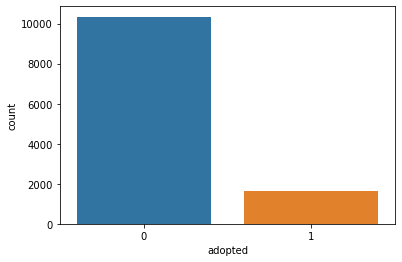

In [280]:
sns.countplot(x="adopted", data=main_df)